In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k #German to English dataset
from torchtext.data import Field, BucketIterator
import numpy as np
import spacy
import random
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


In [2]:
# Other important Functions
import torch
import spacy
from torchtext.data.metrics import bleu_score
import sys


def translate_sentence(model, sentence, german, english, device, max_length=50):
    # print(sentence)

    # sys.exit()

    # Load german tokenizer
    spacy_ger = spacy.load("de")

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # print(tokens)

    # sys.exit()
    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]


def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

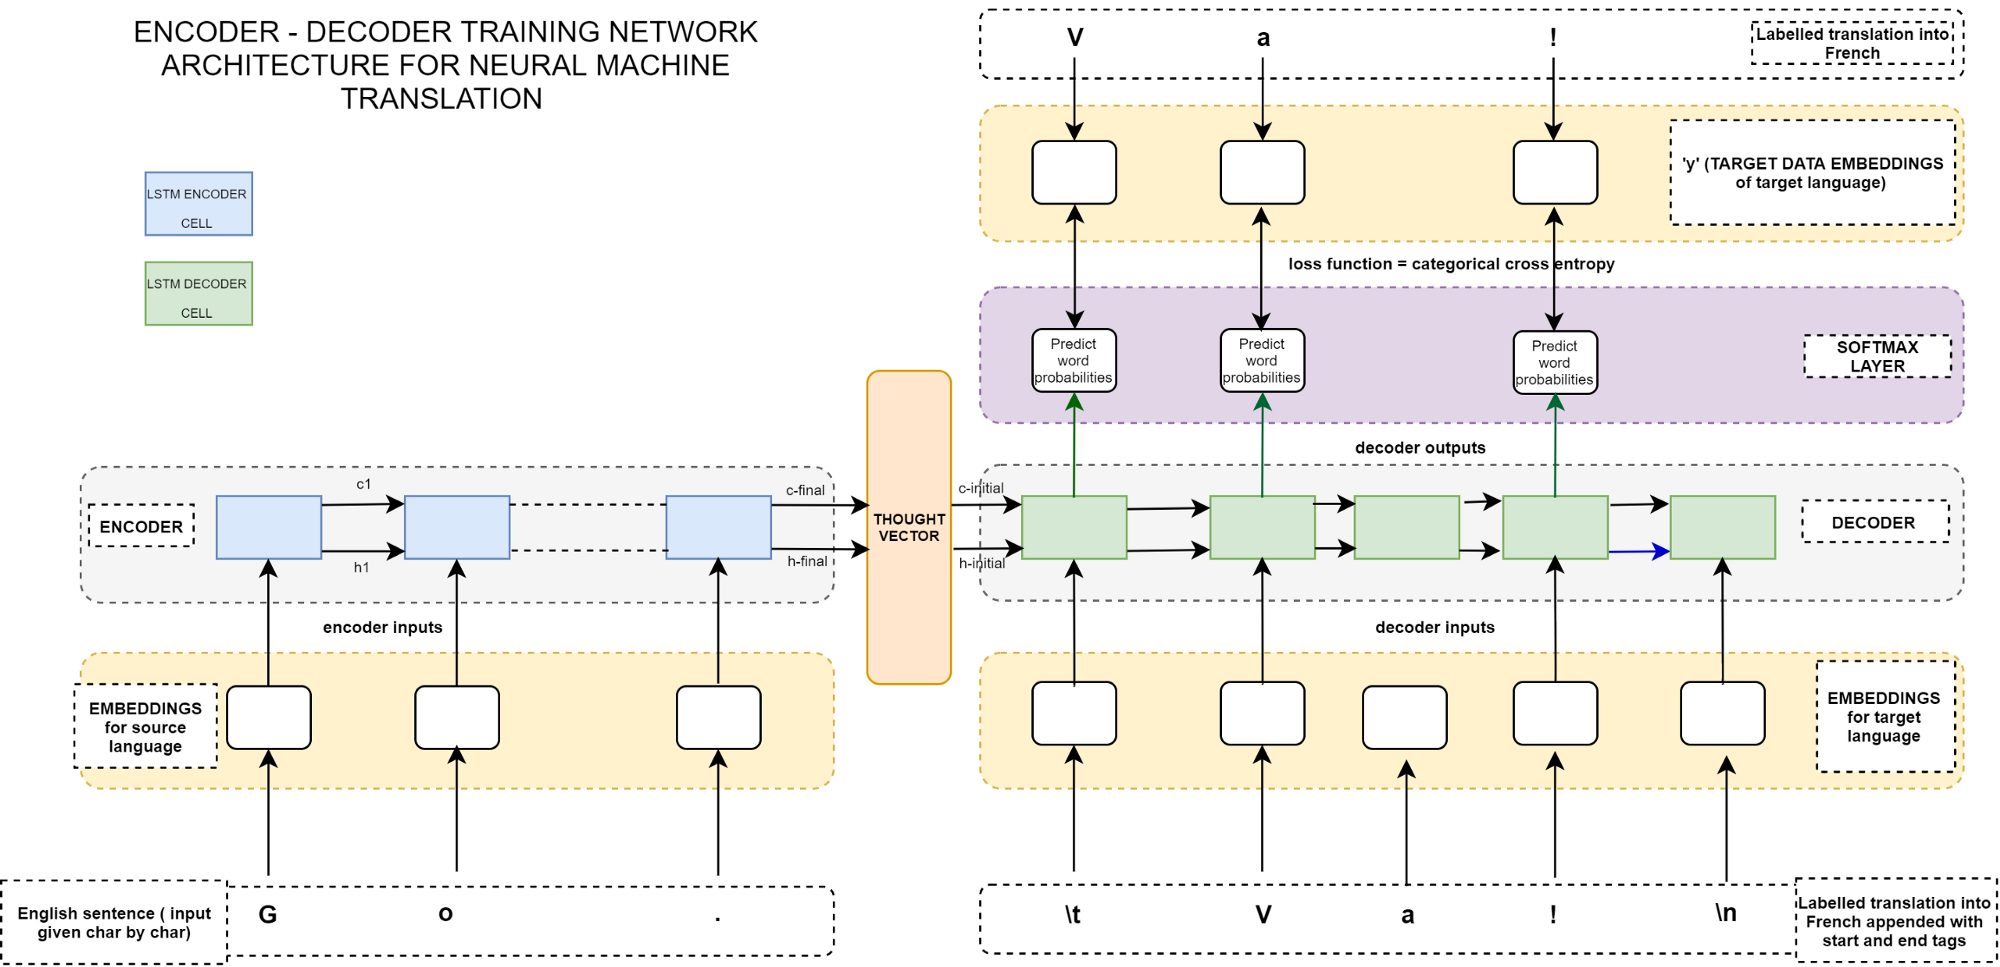

In [3]:
!python -m spacy download de

     |████████████████████████████████| 14.9 MB 2.8 MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=830fb71e6ede777681dcdf37f5871b976ca16e6402aa8eca0cba68d365fbaeb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bhjxswk/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/de_core_news_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
# Loading Tokeniser in german and English
spacy_ger = spacy.load('de')
spacy_eng = spacy.load('en')

In [5]:
def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]

In [6]:
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

## Preprocessing of Text

In [7]:
german = Field(tokenize = tokenize_ger,lower = True,init_token = '<sos>',eos_token = '<eos>')

In [8]:
english = Field(tokenize = tokenize_eng,lower = True,init_token = '<sos>',eos_token = '<eos>')

In [9]:
# Dwonloading Dataset and storing them
train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 807kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 245kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 237kB/s]


In [10]:
# Creating vocabulary in each language
german.build_vocab(train_data,max_size = 10000,min_freq = 2)
english.build_vocab(train_data,max_size = 10000,min_freq = 2)


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        return hidden, cell

In [12]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [14]:
# Hyperparameters
num_epochs = 20
learning_rate = 0.001
batch_size = 64


In [15]:
# Model hyperparameters
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300

hidden_size = 1024
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5


In [16]:
# Tensorboard to get nice loss plot
writer = SummaryWriter(f'runs/Loss_plot')
step = 0

In [17]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
     batch_size = batch_size, sort_within_batch = True, 
     sort_key = lambda x:len(x.src),
     device = device)

In [18]:
encoder_net = Encoder(input_size_encoder, 
                      encoder_embedding_size,
                      hidden_size,num_layers, 
                      enc_dropout).to(device)


decoder_net = Decoder(input_size_decoder, 
                      decoder_embedding_size,
                      hidden_size,output_size,num_layers, 
                      dec_dropout).to(device)

In [19]:
model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
pad_idx = english.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)



In [21]:
if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


In [22]:
sentence = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen."


In [23]:
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = translate_sentence(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        # Forward prop
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        # Plot to tensorboard
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1

[Epoch 0 / 20]
=> Saving checkpoint
Translated example sentence: 
 ['zombie', 'penn', 'penn', 'entrance', 'prepare', 'prepare', 'wrangle', 'eyeglasses', 'eyeglasses', 'ties', 'ties', 'grid', 'ties', 'common', 'greet', 'eyeglasses', 'ties', 'grid', 'ties', 'ties', 'grid', 'sings', 'sings', 'sings', 'sings', 'peer', 'thinking', 'thinking', 'register', 'hide', 'meter', 'sky', 'containing', 'containing', 'billy', 'billy', 'containing', 'surface', 'surface', 'toast', 'surface', 'toast', 'slopes', 'eyeglasses', 'eyeglasses', 'blur', 'tackled', 'ties', 'tackled', 'ties']
[Epoch 1 / 20]
=> Saving checkpoint
Translated example sentence: 
 ['a', 'young', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'and', 'a', 'a', 'a', 'a', '.', '<eos>']
[Epoch 2 / 20]
=> Saving checkpoint
Translated example sentence: 
 ['a', '<unk>', 'player', 'with', 'a', '<unk>', '<unk>', 'is', '<unk>', 'a', 'a', 'a', 'a', '.', '<eos>']
[Epoch 3 / 20]
=> Saving checkpoint
Translated example sentence: 
 ['a', '<unk>', 'with

In [24]:

score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

Bleu score 19.43
